# Predicting Boston Housing Prices with Linear Regression (From Scratch)

This project applies a from-scratch implementation of **multiple linear regression** to the classic **Boston Housing** dataset. The goal is to predict **median house prices (MEDV)** based on various socio-economic and environmental factors.

This notebook showcases:
- Manual implementation of gradient descent
- Feature scaling and learning rate (alpha) tuning
- Polynomial feature engineering for capturing non-linear effects
- Reglularization for generability



---
We'll use common Python libraries for data handling, visualization, and statistical analysis.



In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import math
import copy
from sklearn.preprocessing import StandardScaler


---
## Dataset Overview: Boston Housing

This dataset includes features related to housing and neighborhood conditions in Boston suburbs. The goal is to predict **MEDV**, the median value of owner-occupied homes (in $1000s).

### Key Features:
- **CRIM** — Per capita crime rate by town  
- **ZN** — Proportion of residential land zoned for lots over 25,000 sq.ft.  
- **INDUS** — Proportion of non-retail business acres per town  
- **CHAS** — Charles River dummy variable (1 if tract bounds river, 0 otherwise)  
- **NOX** — Nitric oxides concentration (parts per 10 million)  
- **RM** — Average number of rooms per dwelling  
- **AGE** — Proportion of owner-occupied units built before 1940  
- **DIS** — Weighted distance to five Boston employment centers  
- **RAD** — Index of accessibility to radial highways  
- **TAX** — Full-value property tax rate per $10,000

And many more


In [54]:
# Download the latest Boston Housing dataset from Kaggle
path = kagglehub.dataset_download("arunjangir245/boston-housing-dataset")
print("Path to dataset files:", path)


Path to dataset files: C:\Users\rayya\.cache\kagglehub\datasets\arunjangir245\boston-housing-dataset\versions\2


In [55]:
# Load dataset into DataFrame
df = pd.read_csv("C:/Users/rayya/.cache/kagglehub/datasets/arunjangir245/boston-housing-dataset/versions/2/BostonHousing.csv")
df = df.dropna()
df.head()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


---
## Correlation Analysis and Feature Selection

Since I am building a multiple linear regression model, it is important to select features that demonstrate a clear linear relationship with the target variable (**MEDV**).

To do this, I:
- Created scatter plots for each feature vs. the target to visually inspect linear trends.
- Calculated the **Pearson correlation coefficient (r)** and **r²** for each feature.

> An r-value near 1 or -1 indicates a strong linear relationship. An r-value near 0 suggests little to no linear correlation.

Based on these values, I chose features that either showed strong relationships or moderate ones that may still contribute in combination with others.


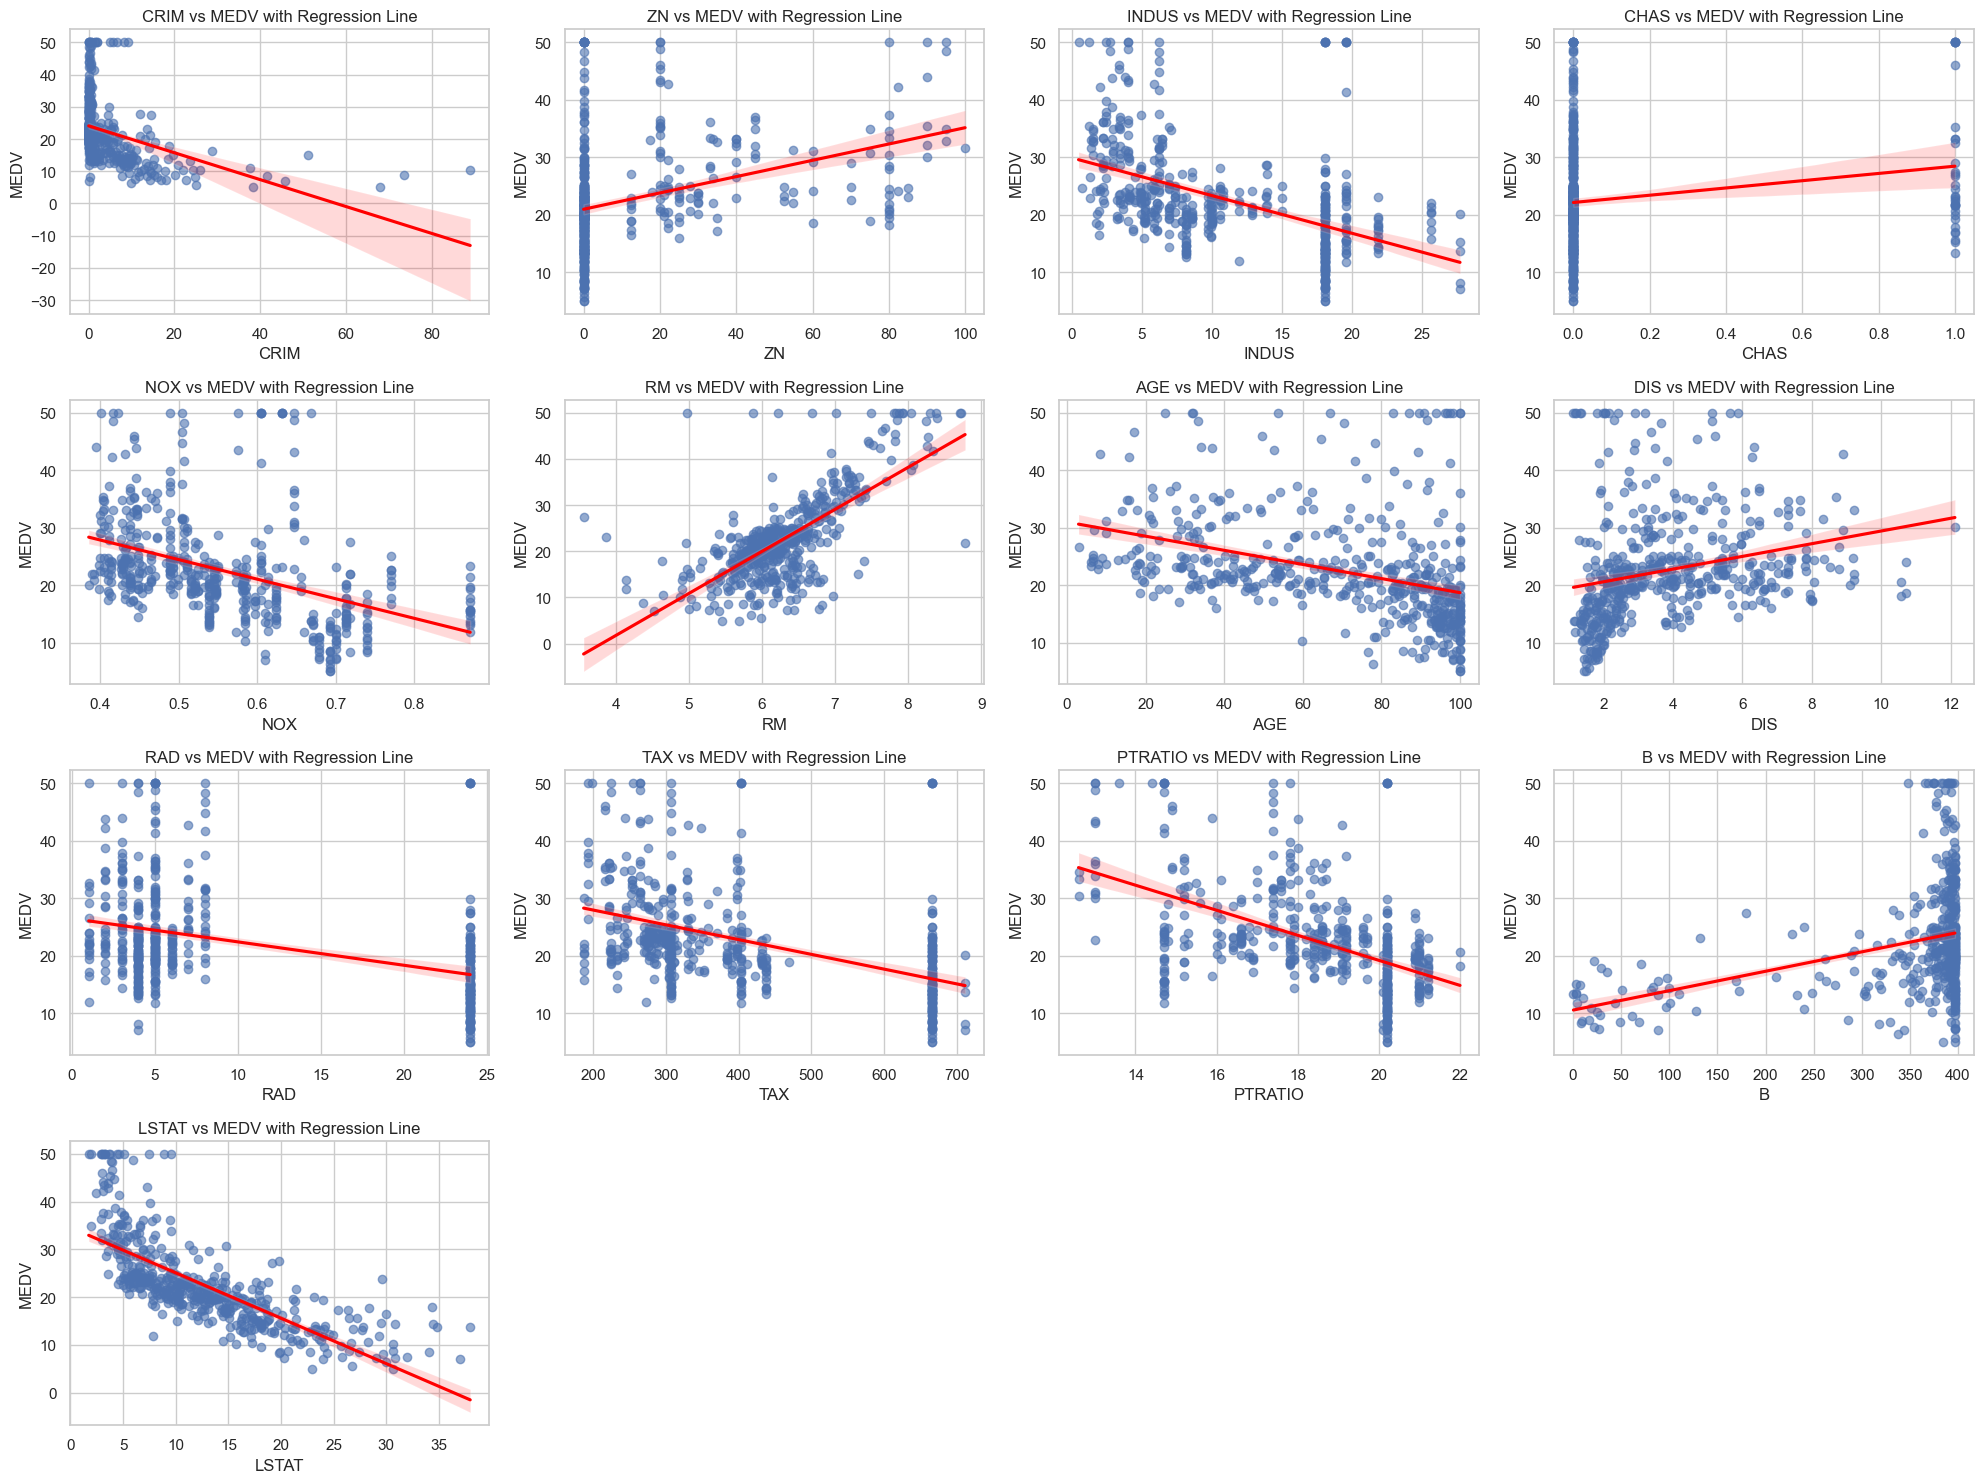

In [57]:
sns.set(style="whitegrid")
features = [col for col in df.columns if col != 'medv']

plt.figure(figsize=(20, 15))

for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.regplot(data=df, x=feature, y='medv', scatter_kws={'alpha':0.6}, line_kws={"color":"red"})
    plt.title(f'{feature.upper()} vs MEDV with Regression Line')
    plt.xlabel(feature.upper())
    plt.ylabel('MEDV')

plt.tight_layout()
plt.show()


In [58]:
print("Feature  |   r     |   r^2")
print("-" * 26)

for feature in features:
    r = df[feature].corr(df['medv'])
    r_squared = r**2
    print(f"{feature:<8} | {r:.3f} | {r_squared:.3f}")


Feature  |   r     |   r^2
--------------------------
crim     | -0.390 | 0.152
zn       | 0.360 | 0.130
indus    | -0.487 | 0.237
chas     | 0.175 | 0.031
nox      | -0.429 | 0.184
rm       | 0.696 | 0.485
age      | -0.375 | 0.141
dis      | 0.252 | 0.063
rad      | -0.385 | 0.148
tax      | -0.471 | 0.222
ptratio  | -0.512 | 0.262
b        | 0.335 | 0.112
lstat    | -0.738 | 0.544


## Final Selected Features

Based on both the correlation values and visual patterns, I selected the following features:

```python
features = ['lstat', 'rm', 'ptratio', 'indus', 'tax', 'nox', 'rad', 'crim', 'age', 'zn', 'b']
```

It's important to note that while many of the r values are closer to 0 (indicating weak individual linear relationships), this is not necessarily a problem. Since multiple linear regression is a multivariate technique, features that individually explain only a small amount of variance can still contribute valuable information when combined with other features in the model. Another reason to include weak individual linear relationships is that with the help of feature engineering we can capture non-linear relationships by fitting curve.

In [60]:
features = ['lstat', 'rm', 'ptratio', 'indus', 'tax', 'nox', 'rad', 'crim', 'age', 'zn', 'b']

X_train = df[features]
y_train = df['medv']


---
##  Building the Linear Regression Model (From Scratch)

Now let us **build our linear regression model** using NumPy — without relying on high-level libraries like scikit-learn.

This section includes:
- A **prediction function** that computes outputs using the current weights and bias  
- A **cost function** that evaluates how far our predictions are from the actual values  
- A **gradient computation** function to calculate the direction and magnitude of updates  
- A **gradient descent algorithm** that iteratively updates parameters to minimize the cost

These components together form the backbone of training a linear regression model from scratch.


In [62]:
def prediction(X, w, b):
    """ 
    Computes the predicted housing prices using the linear regression model.

    Args:
        X (ndarray): Feature matrix of shape (m, n), where m is the number of examples 
                     and n is the number of features (e.g., crime rate, number of rooms, etc.).
        w (ndarray): Weight vector of shape (n,), representing the coefficients for each feature.
        b (float): Bias term (intercept).

    Returns:
        ndarray: Predicted housing prices of shape (m,), one prediction per example.
    """
    pre = np.dot(X, w) + b
    return pre
    

In [63]:
def cost_function(X, y, w, b, lamb):
    """
    Computes the cost (mean squared error) for linear regression.

    Args:
        X (ndarray): Feature matrix of shape (m, n).
        y (ndarray): Target values (actual housing prices), shape (m,).
        w (ndarray): Weight vector of shape (n,).
        b (float): Bias term.

    Returns:
        float: The cost value, representing how far predictions are from actual prices.
    """
    m = X.shape[0]
    pre = prediction(X, w, b)

    cost = np.sum((pre - y)**2) / (2 * m) + (lamb/ (2 * m)) * np.sum(np.square(w))
    return cost

In [64]:
def compute_gradient(X, y, w, b, lamb):
    """
    Computes the gradients of the cost function with respect to the weights and bias.

    Args:
        X (ndarray): Feature matrix of shape (m, n).
        y (ndarray): Target values (actual housing prices), shape (m,).
        w (ndarray): Current weight vector of shape (n,).
        b (float): Current bias term.

    Returns:
        dj_dw (ndarray): Gradient of the cost with respect to weights, shape (n,).
        dj_db (float): Gradient of the cost with respect to the bias.
    """
    m, n = X.shape
    pre = prediction(X, w, b)
    dj_dw = np.zeros(n)
    dj_db = 0

    for i in range(m):

        dj_dw = dj_dw + (pre[i] - y[i]) * X[i, :]
        dj_db = dj_db + (pre[i] - y[i]) 
        
    dj_dw = dj_dw / m + (lamb / m) * w 
    dj_db = dj_db / m
    
    return dj_dw, dj_db

In [65]:
def gradient_descent(X, y, w_init, b_init, cost_function, gradient_function, alpha, lamb, num_iters):
    """
    Performs gradient descent to learn weights and bias for linear regression.

    Args:
        X (ndarray): Feature matrix of shape (m, n).
        y (ndarray): Target values (actual housing prices), shape (m,).
        w_init (ndarray): Initial weight vector of shape (n,).
        b_init (float): Initial bias term.
        alpha (float): Learning rate.
        num_iter (int): Number of iterations to run gradient descent.

    Returns:
        w (ndarray): Optimized weight vector.
        b (float): Optimized bias term.
    """
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_init)
    b = b_init

    for i in range(num_iters):
        dj_dw, dj_db = gradient_function(X, y, w, b, lamb)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 100000:
            cost = cost_function(X, y, w, b, lamb)
            J_history.append(cost)

        if i % math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
            
        
    return w, b, J_history, w_history
    

---
## Training the Model Using Gradient Descent

Now let us **train the model** using the gradient descent algorithm we implemented.

This involves:
- Initializing weights and bias to zero (or small random values)
- Iteratively updating them using the computed gradients
- Monitoring the cost to ensure it decreases over time

This training loop helps the model learn the optimal parameters that minimize the mean squared error between predictions and actual housing prices.


In [67]:
from sklearn.preprocessing import PolynomialFeatures

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)

poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(X_train_scaled)

w_init = np.zeros(X_poly.shape[1])
b_init = 0
alpha = 0.001  
lamb = 1
iterations = 10000

w_final, b_final, J_history, w_history = gradient_descent(
    X_poly,
    y_train.values,
    w_init,
    b_init,
    cost_function,
    compute_gradient,
    alpha,
    lamb,
    iterations
)


Iteration    0: Cost   285.57   
Iteration 1000: Cost    18.50   
Iteration 2000: Cost    13.67   
Iteration 3000: Cost    11.68   
Iteration 4000: Cost    10.48   
Iteration 5000: Cost     9.63   
Iteration 6000: Cost     8.98   
Iteration 7000: Cost     8.45   
Iteration 8000: Cost     8.02   
Iteration 9000: Cost     7.66   


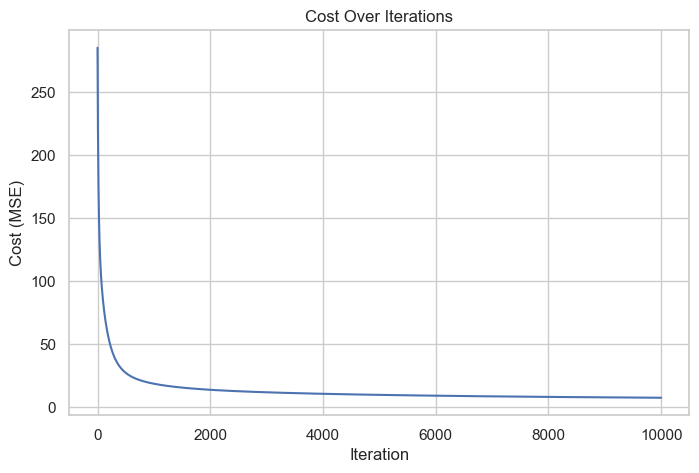

In [68]:
# Plot cost over iterations to verify convergence
plt.figure(figsize=(8, 5))
plt.plot(J_history)
plt.title("Cost Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE)")
plt.grid(True)
plt.show()


---
## Making Predictions and Evaluating the Model

With our model trained and weights optimized, it's time to assess how well it performs. We'll use the learned parameters (`w_final`, `b_final`) to make predictions and evaluate them against the actual target values.

This step includes:
- Making predictions using the learned linear model
- Visualizing the predicted values versus the actual values
- Computing quantitative performance metrics

---

###  Make Predictions on Training Data
We use the `prediction` function we defined earlier:

```python
y_pred = prediction(X_train_scaled, w_final, b_final)


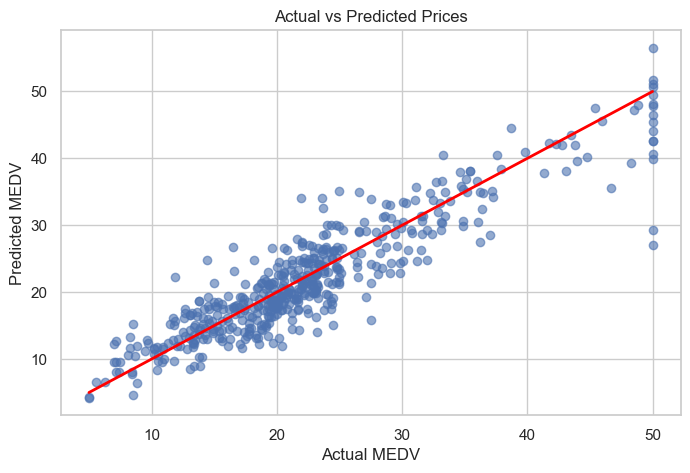

In [85]:

y_pred = prediction(X_poly, w_final, b_final)
plt.figure(figsize=(8, 5))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.show()


---
## References
- Andrew Ng's Machine Learning Specialization (Coursera)
- Khan Academy College Statistics course (used for understanding coefficient of determination)
